# Calculating Elder Impulse for long view

In [1]:
# IMPORTING PACKAGES

import pandas as pd
import requests
from datetime import datetime, timedelta
import talib
import matplotlib.pyplot as plt


/var/folders/sk/ckljlph97j1grnldzlf4khtc0000gn/T/ipykernel_24339/172189558.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Getting historical data from binance API

In [33]:
#The variable days_back represents the number of days in the past from which I intend to retrieve the data.
#The variable symbol is a coin pair. For example if you want bitcoin historical data, the symbol to use is BTCUSDT. 

API_URL = 'https://api.binance.com/api/v3/klines' # Binance API endpoint for candlestick data

def get_historical_data(symbol, days_back, interval):
    # Calculate the start time in milliseconds
    start_time = int((datetime.now() - timedelta(days=days_back)).timestamp() * 1000)

    # Calculate the current time in milliseconds
    end_time = int(datetime.now().timestamp() * 1000)

    # Make an API request to retrieve historical data
    hist_json = requests.get(API_URL, params={
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 1000  # Maximum number of data points per request
    }).json()
    
    # Making a df from response
    # Extract only the relevant elements for each row
    df = pd.DataFrame(hist_json, columns=[
        'Time', 'Open Price', 'High Price', 'Low Price',
        'Close Price', 'Volume', 'Kline Close Time', 'Quote Asset Volume',
        'Number of Trades', 'Taker Buy Base Asset Volume',
        'Taker Buy Quote Asset Volume', 'Unused Field'
    ])

    # Select only the relevant columns (Open Time, Open Price, High Price, Low Price, Close Price, Volume)
    df = df[['Time', 'Open Price', 'High Price', 'Low Price', 'Close Price', 'Volume']]
    df['dateTime'] = pd.to_datetime(df['Time'], unit='ms')
    
    return df


In [35]:
def transform_hist_data(df_name):
    df_name['Open Price'] = pd.to_numeric(df_name['Open Price'], errors='coerce').astype(float)
    df_name['High Price'] = pd.to_numeric(df_name['High Price'], errors='coerce').astype(float)
    df_name['Low Price'] = pd.to_numeric(df_name['Low Price'], errors='coerce').astype(float)
    df_name['Close Price'] = pd.to_numeric(df_name['Close Price'], errors='coerce').astype(float)
    df_name['Volume'] = pd.to_numeric(df_name['Volume'], errors='coerce').astype(float)
    return df_name


## Creating a table for calculating elder impulse

Elder Impulse
https://school.stockcharts.com/doku.php?id=chart_analysis:elder_impulse_system
MACD-histogram
https://www.investopedia.com/ask/answers/122414/what-moving-average-convergence-divergence-macd-formula-and-how-it-calculated.asp

In [64]:
df_long = get_historical_data('BTCUSDT', 360, '1w')


In [65]:
df_long.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         52 non-null     int64         
 1   Open Price   52 non-null     object        
 2   High Price   52 non-null     object        
 3   Low Price    52 non-null     object        
 4   Close Price  52 non-null     object        
 5   Volume       52 non-null     object        
 6   dateTime     52 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.0+ KB


In [66]:
df_long.shape

(52, 7)

In [67]:
df_long = transform_hist_data(df_long)

In [68]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         52 non-null     int64         
 1   Open Price   52 non-null     float64       
 2   High Price   52 non-null     float64       
 3   Low Price    52 non-null     float64       
 4   Close Price  52 non-null     float64       
 5   Volume       52 non-null     float64       
 6   dateTime     52 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.0 KB


In [69]:
#Function for calculating EMA-s
def calculate_emas(df_name):
    df_name['13EMA'] = df_name['Close Price'].ewm(span=13, adjust=False).mean()
    df_name['12EMA'] = df_name['Close Price'].ewm(span=12, adjust=False).mean()
    df_name['26EMA'] = df_name['Close Price'].ewm(span=26, adjust=False).mean()
    return df_name
    

In [70]:
df_long = calculate_emas(df_long)

In [71]:
def calculate_macd(df_name):
    # Calculate MACD Line (12EMA - 26EMA)
    df_name['MACD'] = df_name['12EMA'] - df_name['26EMA']

    # Calculate Signal Line (9-period EMA of MACD)
    df_name['Signal'] = df_name['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate MACD Histogram
    df_name['Histogram'] = df_name['MACD'] - df_name['Signal']
    return df_name
    

In [72]:
df_long = calculate_macd(df_long)

In [73]:
df_long.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,13EMA,12EMA,26EMA,MACD,Signal,Histogram
47,1705881600000,41580.32,42842.68,38555.00,42031.06,274603.16207,2024-01-22,39773.009000,40098.155665,36244.972877,3853.182789,3561.402318,291.780470
48,1706486400000,42031.05,43882.36,41804.88,42582.88,203036.61925,2024-01-29,40174.419143,40480.420948,36714.447478,3765.973469,3602.316549,163.656921
49,1707091200000,42582.88,48592.66,42258.10,48299.99,262240.48357,2024-02-05,41335.214979,41683.431571,37572.635813,4110.795758,3704.012390,406.783367
50,1707696000000,48300.00,52816.62,47710.01,52137.67,310862.30170,2024-02-12,42878.422840,43291.775945,38651.527234,4640.248710,3891.259654,748.989056
51,1708300800000,52137.68,52985.00,51311.00,51530.00,62143.22506,2024-02-19,44114.362434,44559.195030,39605.488180,4953.706850,4103.749094,849.957757


## Calculating elder impulse

In [9]:
last_row_13ema = df_long.iloc[-1]['13EMA']
second_to_last_row_13ema = df_long.iloc[-2]['13EMA']
# Print the comparison
print(f"Last row EMA_13: {last_row_13ema}")
print(f"Second-to-last row EMA_13: {second_to_last_row_13ema}")

Last row EMA_13: 45371.30498125781
Second-to-last row EMA_13: 44300.402478134114


In [10]:
ema_comparison = 0

if last_row_13ema > second_to_last_row_13ema:
    ema_comparison = 1
elif last_row_13ema < second_to_last_row_13ema:
    ema_comparison = -1

ema_comparison

1

In [11]:
elder_impulse = 0

if ema_comparison == 1 and df_long['Histogram'].iloc[-1] > 0:
    elder_impulse = 1
elif ema_comparison == -1 and df_long['Histogram'].iloc[-1] < 0:
    elder_impulse = -1
else:
    elder_impulse = 0

elder_impulse

1

In [75]:
'''for i in range(1, len(df_long)):
    row_1_13ema = df_long.iloc[i - 1]['13EMA']
    second_to_last_row_13ema = df_long.iloc[i - 2]['13EMA']
    ema_comparison = 0

    if last_row_13ema > second_to_last_row_13ema:
        ema_comparison = 1
    elif last_row_13ema < second_to_last_row_13ema:
        ema_comparison = -1

    if ema_comparison == 1 and df_long['Histogram'].iloc[i] > 0:
        df_long.at[i, 'elder_impulse'] = 1
    elif ema_comparison == -1 and df_long['Histogram'].iloc[i] < 0:
        df_long.at[i, 'elder_impulse'] = -1
'''

"for i in range(1, len(df_long)):\n    row_1_13ema = df_long.iloc[i - 1]['13EMA']\n    second_to_last_row_13ema = df_long.iloc[i - 2]['13EMA']\n    ema_comparison = 0\n\n    if last_row_13ema > second_to_last_row_13ema:\n        ema_comparison = 1\n    elif last_row_13ema < second_to_last_row_13ema:\n        ema_comparison = -1\n\n    if ema_comparison == 1 and df_long['Histogram'].iloc[i] > 0:\n        df_long.at[i, 'elder_impulse'] = 1\n    elif ema_comparison == -1 and df_long['Histogram'].iloc[i] < 0:\n        df_long.at[i, 'elder_impulse'] = -1\n"

if elder_impulse is 1, it means you can go long; 
if it is -1 , you can go short;
if it is 0 you can do both. 
It is best to go long if impulse is 1 or 0 after -1. (This should be considered good metricks for stock screening)

# Creating Medium view and ATR channels

In [12]:
df_medium = get_historical_data('BTCUSDT', 30, '1d')

In [13]:
df_medium.head()


,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime
0,1705881600000,41580.32000000,41689.65000000,39431.58000000,39568.02000000,55426.19911000,2024-01-22
1,1705968000000,39568.02000000,40176.74000000,38555.00000000,39897.60000000,57956.63351000,2024-01-23
2,1706054400000,39897.59000000,40555.00000000,39484.19000000,40084.88000000,39293.82861000,2024-01-24
3,1706140800000,40084.89000000,40300.24000000,39550.00000000,39961.09000000,31022.11853000,2024-01-25
4,1706227200000,39961.09000000,42246.82000000,39822.52000000,41823.51000000,47384.96726000,2024-01-26


In [14]:
df_medium.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         30 non-null     int64         
 1   Open Price   30 non-null     object        
 2   High Price   30 non-null     object        
 3   Low Price    30 non-null     object        
 4   Close Price  30 non-null     object        
 5   Volume       30 non-null     object        
 6   dateTime     30 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.8+ KB


In [15]:
df_medium['Open Price'] = pd.to_numeric(df_medium['Open Price'], errors='coerce').astype(float)
df_medium['High Price'] = pd.to_numeric(df_medium['High Price'], errors='coerce').astype(float)
df_medium['Low Price'] = pd.to_numeric(df_medium['Low Price'], errors='coerce').astype(float)
df_medium['Close Price'] = pd.to_numeric(df_medium['Close Price'], errors='coerce').astype(float)
df_medium['Volume'] = pd.to_numeric(df_medium['Volume'], errors='coerce').astype(float)

In [16]:
df_medium['ATR21'] = talib.ATR(df_medium['High Price'], df_medium['Low Price'], df_medium['Close Price'], timeperiod=21)
df_medium['ATR14'] = talib.ATR(df_medium['High Price'], df_medium['Low Price'], df_medium['Close Price'], timeperiod=14)

In [17]:
df_medium.tail()


,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14
25,1708041600000,51880.01,52572.08,51566.00,52124.11,37772.25318,2024-02-16,1452.933578,1521.895668
26,1708128000000,52124.10,52162.82,50625.00,51642.64,25674.00622,2024-02-17,1456.975789,1523.033120
27,1708214400000,51642.64,52377.00,51163.28,52137.67,21992.10363,2024-02-18,1445.392180,1500.939326
28,1708300800000,52137.68,52488.77,51677.00,51774.73,29534.99432,2024-02-19,1415.219695,1451.712945
29,1708387200000,51774.74,52985.00,51311.00,51796.71,30177.27277,2024-02-20,1427.542567,1467.590592


In [18]:
df_medium['13EMA'] = df_medium['Close Price'].ewm(span=13, adjust=False).mean()

I will choose ATR 21. Now I will create ATR +1, ATR +2, ATR -1 and -2. These are channels. Then we can compare price against these channels to find entry, stop loss and exit.

In [19]:
# Calculate 21-period EMA
df_medium['21EMA'] = df_medium['Close Price'].ewm(span=21, adjust=False).mean()
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA
25,1708041600000,51880.01,52572.08,51566.00,52124.11,37772.25318,2024-02-16,1452.933578,1521.895668,48271.157326,46531.014660
26,1708128000000,52124.10,52162.82,50625.00,51642.64,25674.00622,2024-02-17,1456.975789,1523.033120,48752.797708,46995.707873
27,1708214400000,51642.64,52377.00,51163.28,52137.67,21992.10363,2024-02-18,1445.392180,1500.939326,49236.350893,47463.158975
28,1708300800000,52137.68,52488.77,51677.00,51774.73,29534.99432,2024-02-19,1415.219695,1451.712945,49598.976479,47855.119978
29,1708387200000,51774.74,52985.00,51311.00,51796.71,30177.27277,2024-02-20,1427.542567,1467.590592,49912.938411,48213.446343


In [20]:
df_medium['ATR+1'] = df_medium['21EMA'] + df_medium['ATR21'] 

In [21]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1
25,1708041600000,51880.01,52572.08,51566.00,52124.11,37772.25318,2024-02-16,1452.933578,1521.895668,48271.157326,46531.014660,47983.948239
26,1708128000000,52124.10,52162.82,50625.00,51642.64,25674.00622,2024-02-17,1456.975789,1523.033120,48752.797708,46995.707873,48452.683662
27,1708214400000,51642.64,52377.00,51163.28,52137.67,21992.10363,2024-02-18,1445.392180,1500.939326,49236.350893,47463.158975,48908.551155
28,1708300800000,52137.68,52488.77,51677.00,51774.73,29534.99432,2024-02-19,1415.219695,1451.712945,49598.976479,47855.119978,49270.339673
29,1708387200000,51774.74,52985.00,51311.00,51796.71,30177.27277,2024-02-20,1427.542567,1467.590592,49912.938411,48213.446343,49640.988910


In [22]:
df_medium['ATR+2'] = df_medium['21EMA'] + 2 * df_medium['ATR21'] 
df_medium['ATR+3'] = df_medium['21EMA'] + 3 * df_medium['ATR21'] 

In [23]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1,ATR+2,ATR+3
25,1708041600000,51880.01,52572.08,51566.00,52124.11,37772.25318,2024-02-16,1452.933578,1521.895668,48271.157326,46531.014660,47983.948239,49436.881817,50889.815396
26,1708128000000,52124.10,52162.82,50625.00,51642.64,25674.00622,2024-02-17,1456.975789,1523.033120,48752.797708,46995.707873,48452.683662,49909.659451,51366.635240
27,1708214400000,51642.64,52377.00,51163.28,52137.67,21992.10363,2024-02-18,1445.392180,1500.939326,49236.350893,47463.158975,48908.551155,50353.943335,51799.335515
28,1708300800000,52137.68,52488.77,51677.00,51774.73,29534.99432,2024-02-19,1415.219695,1451.712945,49598.976479,47855.119978,49270.339673,50685.559368,52100.779063
29,1708387200000,51774.74,52985.00,51311.00,51796.71,30177.27277,2024-02-20,1427.542567,1467.590592,49912.938411,48213.446343,49640.988910,51068.531477,52496.074044


In [24]:
df_medium['ATR-1'] = df_medium['21EMA'] - df_medium['ATR21'] 

In [25]:
df_medium['ATR-2'] = df_medium['21EMA'] - 2 * df_medium['ATR21'] 
df_medium['ATR-3'] = df_medium['21EMA'] - 3 * df_medium['ATR21'] 

In [26]:
df_medium.tail()

,Time,Open Price,High Price,Low Price,Close Price,Volume,dateTime,ATR21,ATR14,13EMA,21EMA,ATR+1,ATR+2,ATR+3,ATR-1,ATR-2,ATR-3
25,1708041600000,51880.01,52572.08,51566.00,52124.11,37772.25318,2024-02-16,1452.933578,1521.895668,48271.157326,46531.014660,47983.948239,49436.881817,50889.815396,45078.081082,43625.147503,42172.213925
26,1708128000000,52124.10,52162.82,50625.00,51642.64,25674.00622,2024-02-17,1456.975789,1523.033120,48752.797708,46995.707873,48452.683662,49909.659451,51366.635240,45538.732084,44081.756295,42624.780506
27,1708214400000,51642.64,52377.00,51163.28,52137.67,21992.10363,2024-02-18,1445.392180,1500.939326,49236.350893,47463.158975,48908.551155,50353.943335,51799.335515,46017.766795,44572.374615,43126.982435
28,1708300800000,52137.68,52488.77,51677.00,51774.73,29534.99432,2024-02-19,1415.219695,1451.712945,49598.976479,47855.119978,49270.339673,50685.559368,52100.779063,46439.900282,45024.680587,43609.460892
29,1708387200000,51774.74,52985.00,51311.00,51796.71,30177.27277,2024-02-20,1427.542567,1467.590592,49912.938411,48213.446343,49640.988910,51068.531477,52496.074044,46785.903776,45358.361209,43930.818642


Ma jätan praegu need kaks tabelit siia, nüüd edasine tegevus
* Teeme näitlikustamaks graafiku
* Määra ära entry, stop ja exit
* Proovi ainult bitcoini peale backtestida
* (Peaks tegema screeneri, mis otsib õigeid stocke, et leiaks selle ostu koha vastavalt Elderi impulsile. )

Lihtsalt mõte: kas oleks vaja teha databaas? Iseenesest, mul vaja teada ainult 30 rida iga kord, API asju ei tule väga palju. Kas muutub suuresti midagi, kui iga päev teen ühe eraldi requesti? Iseenesest proovimise mõttes oleks hea uuendada

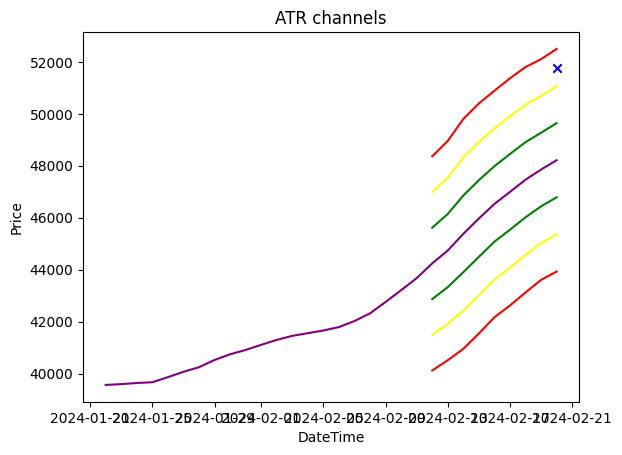

In [27]:
#Stop-i määramine
stop_price = 0

# Plotting multiple lines on the same chart
plt.plot(df_medium['dateTime'], df_medium['21EMA'], label='21EMA', color = 'purple')
plt.plot(df_medium['dateTime'], df_medium['ATR+1'], label='ATR+1',color = 'green')
plt.plot(df_medium['dateTime'], df_medium['ATR+2'], label='ATR+2',color = 'yellow')
plt.plot(df_medium['dateTime'], df_medium['ATR+3'], label='ATR+3',color = 'red')
plt.plot(df_medium['dateTime'], df_medium['ATR-1'], label='ATR-1',color = 'green')
plt.plot(df_medium['dateTime'], df_medium['ATR-2'], label='ATR-2',color = 'yellow')
plt.plot(df_medium['dateTime'], df_medium['ATR-3'], label='ATR-3',color = 'red')

# Show current price with an 'x'
last_price_x = df_medium['dateTime'].iloc[-1]
last_price_y = df_medium['Open Price'].iloc[-1]
plt.scatter(last_price_x, last_price_y, c='blue', marker='x', label='Last Price')

# Adding labels and title
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('ATR channels')
plt.yticks()

plt.show()

# SCREENER

In [28]:
#Ticker list

def get_top_cryptos_with_usdt():
    url = "https://api.binance.com/api/v3/exchangeInfo"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        symbols = data['symbols']
        top_cryptos_usdt = [symbol['symbol'] for symbol in symbols if 'USDT' in symbol['symbol']]
        return top_cryptos_usdt[:20]  # Adjust the limit based on your requirements
    else:
        print(f"Error: {response.status_code}")
        return None

# Run the function
top_cryptos_usdt = get_top_cryptos_with_usdt()

# Display the results
if top_cryptos_usdt:
    print("Top 20 trading pairs with USDT:")
    for crypto in top_cryptos_usdt:
        print(crypto)
else:
    print("Failed to retrieve data.")


Top 20 trading pairs with USDT:
BTCUSDT
ETHUSDT
BNBUSDT
BCCUSDT
NEOUSDT
LTCUSDT
QTUMUSDT
ADAUSDT
XRPUSDT
EOSUSDT
TUSDUSDT
IOTAUSDT
XLMUSDT
ONTUSDT
TRXUSDT
ETCUSDT
ICXUSDT
VENUSDT
NULSUSDT
VETUSDT


In [29]:
top_cryptos_usdt

['BTCUSDT',
 'ETHUSDT',
 'BNBUSDT',
 'BCCUSDT',
 'NEOUSDT',
 'LTCUSDT',
 'QTUMUSDT',
 'ADAUSDT',
 'XRPUSDT',
 'EOSUSDT',
 'TUSDUSDT',
 'IOTAUSDT',
 'XLMUSDT',
 'ONTUSDT',
 'TRXUSDT',
 'ETCUSDT',
 'ICXUSDT',
 'VENUSDT',
 'NULSUSDT',
 'VETUSDT']